# Scalar Wave Equation 
# Second Order in Time with Damping and Periodic Forcing 
# Separation of Variables, Eigenmodes and Fast Fourier Analysis

## Import Packages 

In [1]:
using LinearAlgebra
using FFTW 
using Plots 

## Section 1: Introduction 

Here we study the scalar (acoustic pressure) second-order non-linear wave equation with damping and periodic forcing. We include damping (and thus the disappearance of the homogeneous solution over time). Our goal is to define reference data for the numerical work. 

We consider the following three cases (or scenarios) 
  
1. <b>Case-(1/3)</b>: linear, no external forcing and no damping (Natural undamped vibration of a linear string. Frequencies present in the vibration are determined by the initial conditions imposed due to superposition in a linear setting); 
1. <b>Case-(2/3)</b>: linear, including external forcing and excluding damping (Forced vibration of a linear string. After initial transients, the frequency of the vibration is equal to the frequency of the forcing);
1. <b>Case-(3/3)</b>: linear, including external forcing and including damping (Natural damped vibration of a linear string. All frequencies are damped albeit at various rates); 

<b>Problem to solve</b> Let $x \in \Omega=(0,1)$ denote the spatial domain. Let $t \in [0,T]$ denote the time interval. Let $c$ denote the velocity of wave propagation (in units m/s). Let $\gamma$ denote the friction coefficient (in units 1/s). Let $f(x,t)$ denote the time-periodic forcing. The partial differential equation we intend to solve can be written as 

$$
\frac{\partial^2 \, u}{\partial t^2} + \gamma \frac{\partial \, u}{\partial t} 
= c^2 \frac{\partial^2 \, u}{\partial x^2} + f(x,t) 
$$ 

(observe the plus sign in front of $\gamma$ and square of propagation speed). We supply periodic boundary condition for $u(x,t)$ and $\dot{u}(x,t)$, i.e., we impose that 

$$
u(0,t) = u(1,t) \text{ and } \dot{u}(0,t) = \dot{u}(1,t) \, . 
$$

We impose non-zero initial conditions for $u(x,t)$ and zero initial conditions for $\dot{u}(x,t)$, i.e., we impose that

$$
u(x,0) = u_0(x) \text{ and } \dot{u}(x,0) = 0 \, . 
$$

A <b>reference solution</b> (in case of linear equation) can possibly be computed using seperation of variables (implemented using e.g. the function [pde_separate](https://docs.sympy.org/latest/modules/solvers/pde.html) in the sympy package, using e.g. sympy) or using the method of manufactured solutions (we fail to provide provide references here). 

<b>Scenarios to consider</b>: 
1. non-zero initial position, zero initial velocity, and zero external forcing. Periodic boundary conditions are enforced. Analytical solution known. 
2. add damping. Expect solution to die out;
3. add periodic external forcing acting on the entire computational domain (independent of $x$). Expect frequency of forcing to appear in frequency spectra; 
4. add non-linear terms. Expect frequency content to increase;

## Section 2: Case-(1/3): Analytical Solution Including Damping ($\gamma \neq 0$) and Zero Forcing ($f(t) = 0$)

The <b>goal</b> of this section is to provide an analytical reference solution for the numerical simulation by time integration. 

The analytical solution can be found using patience, seperation of variables and Fourier series decomposition. We refer to [Section 7.4 of Vajiac Lecture Notes](https://www.math.hmc.edu/~ajb/PCMI/lecture7.pdf) (has minor typo in the definition of $\omega_n$) among possible other sources. This reference considers a standing wave solution. Homogeneous Dirichlet boundary conditions are employed on both sides of the computational domain. 

The analytical reference solution for the position $u(x,t)$ is given by the infinite series

$$
u(x,t) = \sum_{n=0}^{\infty} u_n(x,t)
\text{ where }
u_n(x,t) = \sin(\omega_n \, t)
$$

The analytical reference solution for the velocity $v(x,t) = \dot{u}(x,t)$ is given by 

$$
v(x,t) = \sum_{n=0}^{\infty} v_n(x,t)
\text{ where }
v_n(x,t) = \omega_n \, \cos(\omega_n \, t)
$$

Both $u(x,t)$ and $v(x,t)$ satisfy the same boundary conditions. The number of modes in the solution of $u(x,t)$ is determined by the initial condition imposed.   

Any analytical solution can be verified setting setting the damping coefficient $\gamma = 0$. If we set $u(x,t) = \sin(n\,\pi\,x) \, \cos(\omega_n \, t)$, then $u_{xx}(x,t) = - n^2 \, \pi^2 \, u(x,t)$ and $u_{tt}(x,t) = - \omega^2 \, \cos(\omega \, t)$. The function is thus a solution in case that $\omega_n = n \, \pi$. In case of zero damping, we have that the initial velocity is equal to zero, i.e., $v(x,t=0) = 0$. 

Initial guess by setting a number of Fourier.  

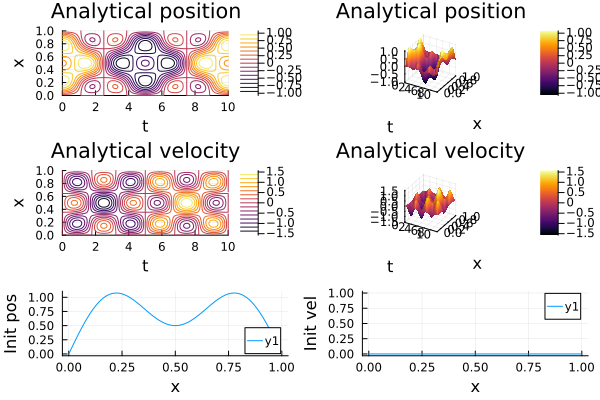

In [6]:
function genAnalyticalSolution(x,t,cosTModeAmp,c,gamma)
    
    nnodes = length(x) 
    Ntp1   = length(t)
    Nmodes = length(cosTModeAmp)
    
    uanal = zeros(nnodes,Ntp1)
    vanal = zeros(nnodes,Ntp1)
    modes = Vector(1:1:Nmodes)
    
    #..construct mode dependent vectors.. 
    alpha = [ c*n*π for n in modes]
    omega = sqrt.(alpha.^2 .- (gamma/2).^2)

    #..construct set of spatial basis vectors satisfying Dirichlet modes on both sides.. 
    X = reduce(hcat,[sin.(n*π*x) for n in modes])

    #..construct set of temporal basis vectors.. 
    CT = reduce(hcat,[exp.(-gamma/2*t).*cos.(omega[n]*t) for n in modes])
    ST = reduce(hcat,[exp.(-gamma/2*t).*sin.(omega[n]*t) for n in modes])
    
    CBasis = [ X[:,n] * Transpose(CT[:,n]) for n in modes]
    SBasis = [ X[:,n] * Transpose(ST[:,n]) for n in modes]
    
    for n in modes uanal = uanal + cosTModeAmp[n] * CBasis[n] end 
    for n in modes vanal = vanal + (-gamma/2*cosTModeAmp[n]) * CBasis[n] + (-omega[n]*cosTModeAmp[n]) * SBasis[n] end 
    
    return uanal, vanal
end 

# set number of elements in space, the number of time samples and number of modes 
nelements = 100;
Nt = 1000; 
Nmodes = 10; 
modes = Vector(1:1:Nmodes)

#..construct the 1D spatial x-mesh and the spatial modes 
nnodes = nelements+1; h = 1/nelements; h2=h*h; 
x = Vector(0:h:1); 
X = reduce(hcat,[sin.(n*π*x) for n in modes])

#..construct temporal t-mesh  
Tend = 10; dt = Tend/Nt; 
t = Vector(0:dt:Tend);

#..set wave velocity and damping coefficients 
c = .2;
gamma = 0. #.75 # 0.5 

#..construct vector of Fourier mode indices in time domain 
cosTModeAmp = zeros(size(modes))
cosTModeAmp[1] = 1; cosTModeAmp[3] = 0.5 

#..initialize and construct analytical solution 
uanal, vanal = genAnalyticalSolution(x,t,cosTModeAmp,c,gamma)

#..initialize and construct initialize position and velocity  
Vinit = zeros(nnodes); Vtinit = zeros(nnodes);
for n in modes Vinit  = Vinit  + cosTModeAmp[n] * X[:,n] end 
for n in modes Vtinit = Vtinit + (-gamma/2)*cosTModeAmp[n] * X[:,n] end 

p1 = contour(t,x,uanal)
xlabel!("t") 
ylabel!("x")
title!("Analytical position")
p2 = surface(t,x,uanal)
xlabel!("t") 
ylabel!("x")
title!("Analytical position")
p3 = contour(t,x,vanal)
xlabel!("t") 
ylabel!("x")
title!("Analytical velocity")
p4 = surface(t,x,vanal)
xlabel!("t") 
ylabel!("x")
title!("Analytical velocity")
p5 = plot(x,Vinit)
xlabel!("x") 
ylabel!("Init pos")
p6 = plot(x,Vtinit)
xlabel!("x") 
ylabel!("Init vel")

plot(p1,p2,p3,p4,p5,p6,layout=(3,2))

## Section 3: Case-(1/4): Second Analytical Solution (to be further elaborated)
Here we intend to replace homogeneous Dirichlet boundary conditions used before by periodic boundary conditions for both $u(x,t)$ and $u_x(x,t)$. 

Assume that $X_n(x) = c_n \, \cos(n \, \pi \, x) + s_n \, \sin(n \, \pi \, x)$. Assume that $(C_1): X_n(0) = X_n(1)$ and that $(C_2): \int_0^1 X_n(x) \, dx = C$. Then $(C_1): $

## Section 4: Case-(1/4): Analytical Solution: Spectral Analysis using Fast-Fourier Transform

Here we intend to look into the spectral of the analytical reference solution by a Fast Fourier Analysis in three points of the spatial domain ($x = 0.25$, $x = 0.5$ and $x = 0.75$). 
- in case that $\gamma = 0$ (no damping), a single peak in frequency domain appears. 
- in case that $\gamma \neq 0$ (no damping), the peak in frequency domain appears is smeared out. The smearing increases with the damping (cfr. FFT of a damped harmonic, provide reference here); 

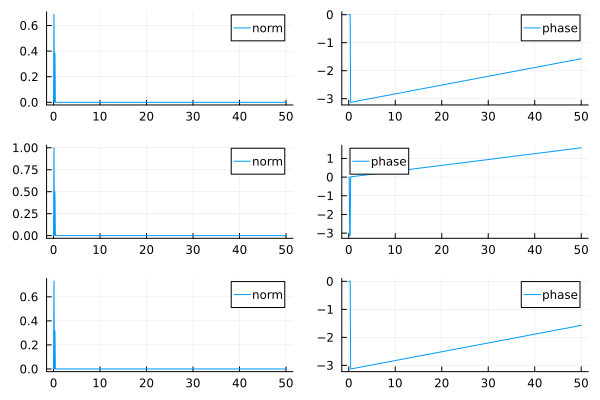

In [5]:
uanalp1 = uanal[div(nelements,4),:]
uanalp2 = uanal[div(nelements,2),:]
uanalp3 = uanal[3*div(nelements,4),:]

p1 = plot(t,uanalp1)
p2 = plot(t,uanalp2)
p3 = plot(t,uanalp3)

plot(p1,p2,p3,layout=(3,1))

# perform FFT of sampled position data 
uanalfp1 = fft(uanalp1)
uanalfp2 = fft(uanalp2)
uanalfp3 = fft(uanalp3)

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nt
fvec = Vector(0:fstep:fmax)

#..plot absolute value of FFT samples  
p1 = plot(fvec, 2.0/Nt * abs.(uanalfp1[1:length(fvec)]),label="norm")
p2 = plot(fvec, angle.(uanalfp1[1:length(fvec)]),label="phase")
p3 = plot(fvec, 2.0/Nt * abs.(uanalfp2[1:length(fvec)]),label="norm")
p4 = plot(fvec, angle.(uanalfp2[1:length(fvec)]),label="phase")
p5 = plot(fvec, 2.0/Nt * abs.(uanalfp3[1:length(fvec)]),label="norm")
p6 = plot(fvec, angle.(uanalfp3[1:length(fvec)]),label="phase")
plot(p1, p2, p3, p4, p5, p6, layout = (3,2))